<p style="font-family:Times New Roman; font-size:120%">
    -Aleksander Nistad Sekkelsten
</p>
<h1 style="font-family:Times New Roman; font-size: 300%"><center> Midterm Exam FYS4110 </center></h1>

<p style="font-family:Times New Roman; font-size:120%">
    We define the harmonic oscillator hamiltonian
</p>

$$
H = \frac{\hbar}{2m}\frac{\partial^2}{\partial x^2} \psi(x) + k\frac{1}{2} x^2
$$

In [1]:
import Pkg; Pkg.activate(".julia/environments/v1.10/Project.toml")
using Plots, Random, LinearAlgebra, Statistics, Distributions
using Plots.PlotMeasures
Pkg.add("QuadGK");using QuadGK
theme(:dao)

#Initializing all to one for simplicity
m = 1
k=1
ħ=1
ω = (k/m)

  Activating project at `~/.julia/environments/v1.10`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


1.0

In [3]:

# Potential energy function for the harmonic oscillator
function potential(x)
    return k / 2 * x^2
end

# Energy levels of the harmonic oscillator
function energy(n)
    return ħ * ω * (n + 0.5)
end

# Hermite polynomial H_n(x), used in quantum harmonic oscillator wavefunctions
function hermite_polynomial(x, n::Int)
    if n == 0
        return 1.0
    elseif n == 1
        return 2.0 * x
    else
        # Use recursion relation: H_n(x) = 2x * H_(n-1)(x) - 2*(n-1) * H_(n-2)(x)
        Hnm2 = 1.0  # H_0(x)
        Hnm1 = 2.0 * x  # H_1(x)
        Hn = 0.0
        for k in 2:n
            Hn = 2 * x * Hnm1 - 2 * (k - 1) * Hnm2
            Hnm2, Hnm1 = Hnm1, Hn
        end
        return Hn
    end
end

# Classical turning point based on energy E
function turning_point(E)
    return sqrt(2 * E / k)
end

# Momentum function p(x, E) for a given energy E and position x
function p(x, E)
    if abs(x) < turning_point(E)
        # Real momentum in the classically allowed region
        return abs(sqrt(2 * m * (E - 0.5 * k * x^2)))
    else
        # Imaginary momentum in the classically forbidden region (take absolute value)
        return abs(sqrt(2 * m * (0.5 * k * x^2 - E)))
    end
end

# Phase function θ(x, E) for WKB approximation
function θ_f(x, E)
    # Calculate classical turning point xt based on energy E
    xt = turning_point(E)
    
    # Calculate the value of θ(x) based on the given formula
    result = (m * ω * xt^2 / ħ) * (
        π / 4 - 0.5 * asin(x / xt) - (1 / 4) * sin(2 * asin(x / xt))
    )
    
    return result
end

# Decay integral χ(x) in the forbidden region
function chi(x, E)
    # Calculate classical turning point xt based on energy E
    xt = turning_point(E)
    
    # Calculate χ(x) using the given formula
    return (m * ω * xt^2 / (2 * ħ)) * (
        (x / xt * sqrt(x^2 / xt^2 - 1)) - log(Complex(x / xt + sqrt(x^2 / xt^2 - 1)))
    )
end

# WKB Wave function ψ_WKB(x, E, A) for a given position x, energy E, and normalization constant A
function psi_wkb(x, E, A)
    # Calculate classical turning point xt based on energy E
    xt = turning_point(E)
    
    if abs(x) < xt - 1e-6  # Slightly inside the turning point to avoid singularity
        # Classically allowed region
        px = p(x, E)  # Momentum
        θ = θ_f(x, E)  # Phase function
        return (2 * A) / sqrt(px) * cos(θ - π / 4)
        
    elseif real(x) > xt + 1e-6  # Slightly outside the turning point
        # Classically forbidden region
        px = p(x, E)  # Momentum
        χ = chi(x, E)  # Decay integral
        return A / sqrt(abs(px)) * exp(-χ)
            
    elseif real(x) < -xt - 1e-6  # Slightly outside the turning point on the negative side
        # Classically forbidden region
        px = p(x, E)  # Momentum
        χ = chi(abs(x), E)  # Decay integral
        return A / sqrt(px) * exp(-χ)
    else
        # Near the turning point, interpolate between the regions to avoid divergence at x = xt
        return 0.0
    end
end

# Exact harmonic oscillator wave function ψ_exact(x, n) for a given position x and quantum number n
function psi_exact(x, n)
    # Define dimensionless variable ξ
    ξ = sqrt(m * ω / ħ) * x
    
    # Calculate Hermite polynomial H_n(ξ)
    Hn = hermite_polynomial(ξ, n)
    
    # Calculate normalization factor N_n
    Nn = 1 / sqrt(2^n * factorial(n)) * (m * ω / (π * ħ))^(1/4)
    
    # Return exact wave function value
    return Nn * exp(-0.5 * ξ^2) * Hn
end


# Main function to plot the wave functions for a given quantum number n
function wavefunctions(n)
    # Calculate energy level E for quantum number n
    E = energy(n)
    
    # Calculate classical turning point xt based on energy E
    xt = turning_point(E)
    
    # Define normalization constant A for WKB wave function (estimated)
    A = 4e-1  # Placeholder value, can be replaced by a computed normalization value

    # Define range of x values for plotting
    x_min = -xt * 2
    x_max = xt * 2
    x_vals = range(x_min, x_max, length=1000)

    # Compute WKB wave function values for all x values
    ψ_wkb_vals = [psi_wkb(x, E, A) for x in x_vals]

    # Compute exact wave function values for all x values
    ψ_exact_vals = [psi_exact(x, n) for x in x_vals]
    
    # Shift wave function values by energy level for plotting purposes
    ψ_wkb_vals .+= E
    ψ_exact_vals .+= E
    
    # Return computed x values, WKB wave function values, and exact wave function values
    return x_vals, ψ_wkb_vals, ψ_exact_vals
end

wavefunctions (generic function with 1 method)

In [12]:
lim=6
x = range(-lim,lim, 100) |> collect
pot = potential.(x)

# Call the plotting function for a specific quantum number n
n = 2   # Change n to plot different energy levels
E = energy(n)
xt = turning_point(E)
x_vals, psi_Wkb, psi_Exact = wavefunctions(n)


(-4.47213595499958:0.008953225135134293:4.47213595499958, Number[2.50094799381719 + 0.0im, 2.5009827102163436 + 0.0im, 2.501018608181449 + 0.0im, 2.501055724401229 + 0.0im, 2.501094096571567 + 0.0im, 2.5011337634184403 + 0.0im, 2.5011747647212057 + 0.0im, 2.501217141336254 + 0.0im, 2.501260935221014 + 0.0im, 2.5013061894583237 + 0.0im  …  2.5013061894583237 + 0.0im, 2.501260935221014 + 0.0im, 2.501217141336254 + 0.0im, 2.5011747647212057 + 0.0im, 2.5011337634184403 + 0.0im, 2.501094096571567 + 0.0im, 2.501055724401229 + 0.0im, 2.501018608181449 + 0.0im, 2.5009827102163436 + 0.0im, 2.50094799381719 + 0.0im], [2.50094041018053, 2.5009747734681977, 2.5010103026558883, 2.5010470337720863, 2.5010850038260983, 2.501124250829994, 2.5011648138208686, 2.50120673288343, 2.501250049172909, 2.501294804938288  …  2.501294804938288, 2.501250049172909, 2.50120673288343, 2.5011648138208686, 2.501124250829994, 2.5010850038260983, 2.5010470337720863, 2.5010103026558883, 2.5009747734681977, 2.50094041018

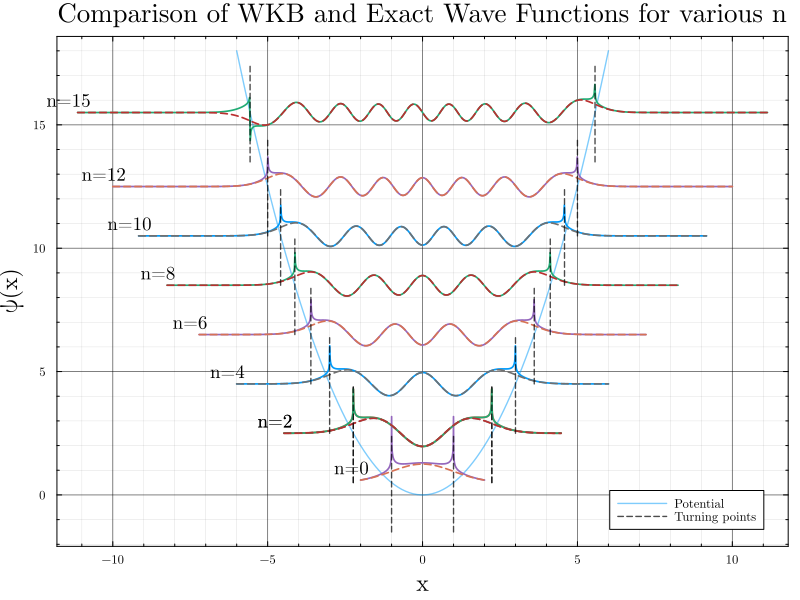

In [13]:


plot(x_vals, real.(psi_Wkb), label=nothing, linewidth=2, size = (900,700))
plot!(x, pot, alpha=0.5, label="Potential")
plot!(x_vals, (psi_Exact), label=nothing, linestyle=:dash, linewidth=1.7)

plot!([-xt,-xt], [E-2, E+2], ls=:dash, c=:black, label="Turning points", alpha=0.7)
plot!([xt,xt], [E-2, E+2], ls=:dash, c=:black,label=nothing, alpha=0.7)

annotate!(x_vals[1]-0.3,psi_Exact[1]+0.5, "n=$n",annotationfontsize=12)
for n in [0,2, 4, 6,8,10,12,15]
    E = energy(n)
    xt = turning_point(E)
    x_vals, psi_Wkb, psi_Exact = wavefunctions(n)

    plot!(x_vals, real.(psi_Wkb), label=nothing, linewidth=1.7, size = (800,600))
    plot!(x_vals, (psi_Exact), label=nothing, linestyle=:dash, linewidth=1.7)
    
    plot!([-xt,-xt], [E-2, E+2], ls=:dash, c=:black, label=nothing, alpha=0.7)
    plot!([xt,xt], [E-2, E+2], ls=:dash, c=:black,label=nothing, alpha=0.7)
    
    annotate!(x_vals[1]-0.3,psi_Exact[1]+0.5, "n=$n",annotationfontsize=12)
end

xlabel!("x", xguidefontsize=15)
plot!(legend=:bottomright)
ylabel!("ψ(x)", yguidefontsize=15)
title!("Comparison of WKB and Exact Wave Functions for various n", titlefontsize=17)
